# Inverse Problems

## Blur + Noise reconstruction

Imports

In [149]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import equinox as eqx
import jax 
import jax.scipy as jsp
import jax.numpy as jnp
import helper as hlp
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Working images 

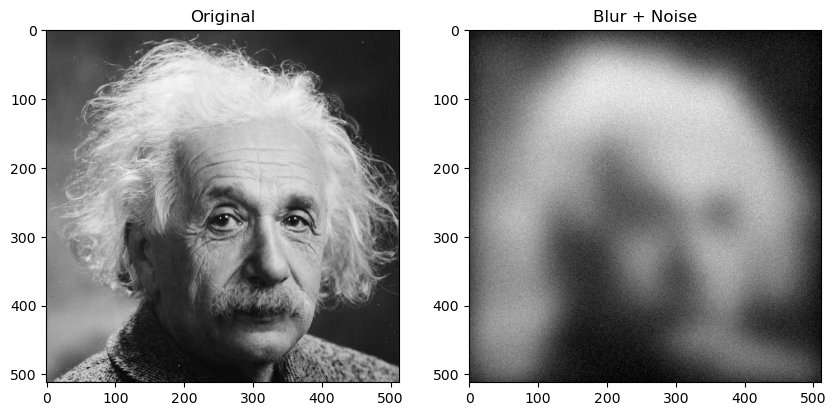

In [159]:
# original img 
img = ski.io.imread('data/img/einstein.tif').astype(np.float32)

# blurred and noisy img
gaussian_kernel = hlp.get_2D_Gaussian_kernel(20)
blur_img = jsp.signal.convolve(img,gaussian_kernel, mode='same')
np.random.seed(4)
gaussian_noise = np.random.normal(0, 10, img.shape)
blur_noise_img = blur_img + gaussian_noise
blur_noise_img= np.clip(blur_noise_img, 0,255)

# plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize =(10,10))
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
plt.show()

Reconstruction

In [137]:
# model 
class Model(eqx.Module):
    kernel: jnp.ndarray
    # y: jnp.ndarray


    def __init__(self, kernel):
        self.kernel = kernel
        # self.y = y

    def __call__(self, x):
        Ax = jsp.signal.convolve(x,self.kernel, mode='same')
        return Ax
    

# loss function 
def loss(x, y, A): # not sure if it's better to put the loss inside the "Model" class
    residual = jnp.linalg.norm(y-A(x))**2
    return residual

# optimizer --> Proximal gradient descent
def optimizer_step(x, y, A, alpha):  # alpha = learning rate
    loss_val, grads_val = jax.value_and_grad(loss)(x, y, A)
    
    # GD update
    x_new = x - alpha * grads_val

    # projection
    x_new = jnp.clip(x_new, 0, 255)

    return loss_val, x_new

In [150]:
# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))


# optimization parameters
alpha = 0.1
n_iter = 100
losses = []

# solve 
for _ in tqdm(range(n_iter)):
    loss_val, x = optimizer_step(x, y, A, alpha) 
    losses.append(loss_val)

100%|██████████| 100/100 [02:43<00:00,  1.64s/it]


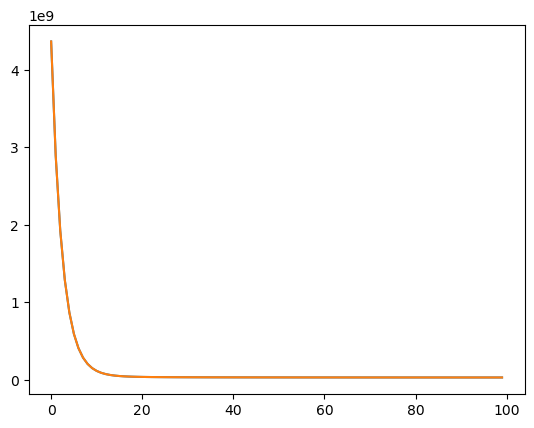

In [156]:
plt.plot(losses)
plt.show()

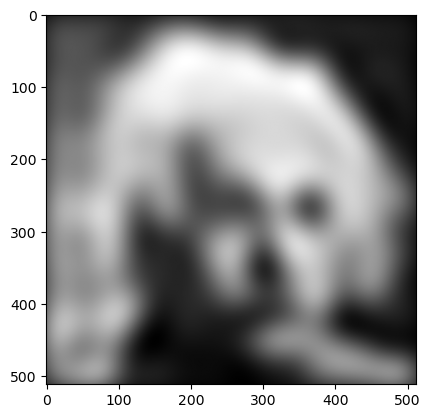

In [157]:
plt.imshow(x, cmap="gray")
plt.show()

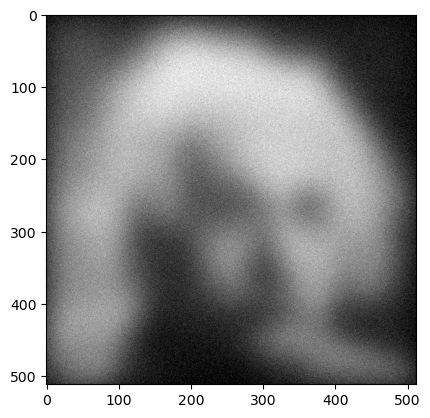

In [158]:
plt.imshow(blur_noise_img, cmap="gray")
plt.show()